In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
import wfdb
import copy as cp
import scipy.signal as signal
import scipy.stats as stats
from sklearn import preprocessing
from tqdm import tqdm
import os
import pathlib
import re
import pandas as pd
import pickle
import csv
import statistics

In [2]:
import timeit

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

from sklearn.preprocessing import PolynomialFeatures

import sklearn.linear_model as skl_lm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeRegressor 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import export_graphviz
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import lightgbm
import lightgbm as lgb
from sklearn.preprocessing import LabelBinarizer

import catboost as cb
from catboost import CatBoostClassifier

C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [4]:
parent_path = str(pathlib.Path(os.path.normpath('C:\\Users\\lms-puvvalat\\Documents\\GitHub\\2022-svsm-afib-group1\\')))

rlist = []
records = os.path.normpath(parent_path + '/mit-bih-dataframes/subject_list.csv')
with open(records) as rfile:
    recordreader = csv.reader(rfile, delimiter=' ', quotechar='|')
    for row in recordreader:
        rlist.append(row[0])

In [3]:
performance_dict = {
    "Model name": [],
    "Avg Accuracy": [],
    "Std Accuracy": [],
    "Sensitivity": [],
    "Specificity": [],
    "Precision": [],
    "F1 score": [],
    "Run time": [],
    "TPS": []
}

moving_accuracy = {}

In [5]:
def score_reporter(initial_results):
    initial_columns = initial_results.axes[0].tolist()
    results = initial_results.dropna()
    changed_columns = results.axes[0].tolist()
    
    dropped_cols = list(set(initial_columns).difference(changed_columns))
    
    print(dropped_cols)

    acc_scores = []
    for x in range(len(rlist)):
        col_name = 'split'+str(x)+'_test_accuracy'
        if col_name not in dropped_cols:
            acc_scores.append(results[col_name])

    spec_scores = []
    for x in range(len(rlist)):
        col_name = 'split'+str(x)+'_test_specificity'
        if col_name not in dropped_cols:
            spec_scores.append(results[col_name])

    sens_scores = []
    for x in range(len(rlist)):
        col_name = 'split'+str(x)+'_test_sensitivity'
        if col_name not in dropped_cols:
            sens_scores.append(results[col_name])


    prec_scores = []
    for x in range(len(rlist)):
        col_name = 'split'+str(x)+'_test_precision'
        if col_name not in dropped_cols:
            prec_scores.append(results[col_name])

    f1_scores = []
    for x in range(len(rlist)):
        col_name = 'split'+str(x)+'_test_f1_score'
        if col_name not in dropped_cols:
            f1_scores.append(results[col_name])
        
    elapsed_times = []
    for x in range(len(rlist)):
        col_name = 'split'+str(x)+'_test_elapsed'
        if col_name not in dropped_cols:
            elapsed_times.append(results[col_name])

    eps_times = []
    for x in range(len(rlist)):
        col_name = 'split'+str(x)+'_test_eps'
        if col_name not in dropped_cols:
            eps_times.append(results[col_name])

    print('---Run time of each fold: \n {}'.format(elapsed_times))
    print("Avg run time: {}".format(np.mean(elapsed_times)))
    print('---Run time per subset of each fold is: \n {}'.format(eps_times))
    print("Avg run time per subset: {}".format(np.mean(eps_times)))
    print()
    print('Accuracy of each fold: \n {}'.format(acc_scores))
    print("Avg accuracy: {}".format(np.mean(acc_scores)))
    print('Std of accuracy : \n{}'.format(np.std(acc_scores)))
    print()
    print('Specificity of each fold: \n {}'.format(spec_scores))
    print("Avg specificity: {}".format(np.mean(spec_scores)))
    print('Std of specificity: \n{}'.format(np.std(spec_scores)))
    print()
    print('Sensitivity of each fold: \n {}'.format(sens_scores))
    print("Avg sensitivity: {}".format(np.mean(sens_scores)))
    print('Std of sensitivity: \n{}'.format(np.std(sens_scores)))
    print()
    print('Precision of each fold: \n {}'.format(prec_scores))
    print("Avg precision: {}".format(np.mean(prec_scores)))
    print('Std of precision : \n{}'.format(np.std(prec_scores)))
    print()
    print('F1-scores of each fold: \n {}'.format(f1_scores))
    print("Avg F1-scores: {}".format(np.mean(f1_scores)))
    print('Std of F1-scores : \n{}'.format(np.std(f1_scores)))

In [6]:
def scorer(clf, X, y):
    global moving_acc

    start_time = timeit.default_timer()
    y_pred = clf.predict(X)
    elapsed = timeit.default_timer() - start_time

    total_seen = 0
    total_correct = 0
    subject_acc = []
    for idx, pred in enumerate(y_pred):
        total_seen+=1
        if pred==y.iloc[idx]:
            total_correct+=1
        subject_acc.append(total_correct/total_seen)
    moving_acc.append(subject_acc)

    fold_size = len(X)

    cm = confusion_matrix(y, y_pred)

    sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
    specificity = cm[1][1]/(cm[1][0]+cm[1][1])
    precision = (cm[0][0])/(cm[0][0]+cm[1][0])
    f1_score = (2*precision*sensitivity)/(precision+sensitivity)

    return {'sensitivity': sensitivity, 'specificity': specificity,
            'precision': precision, 'f1_score': f1_score,
            'accuracy': accuracy_score(y, y_pred), 
            'elapsed': elapsed, 'eps': elapsed/fold_size}

In [7]:
feature_dfs = {}
for record in tqdm(rlist):
    feature_dfs[record] = pd.read_csv(os.path.normpath(parent_path + '/mit-bih-time-features/'+record+'.csv'), index_col=0, dtype={'subjectID': str})

combined_features = pd.concat([feature_dfs[key][1:] for key in feature_dfs])

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.91it/s]


In [8]:
X = combined_features[['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS', 'LtoR', 'LtoL', 'rmssd', 'iqr', 'mad', 'cov']]
y = combined_features['mappedLabel'].map({"Non-Afib": 0, "Afib": 1})
groups = combined_features['subjectID'].astype('int64')

logo = LeaveOneGroupOut()
splits = list(logo.split(X, y, groups=groups))

random search started
Fitting 23 folds for each of 5 candidates, totalling 115 fits


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END ...................................n_estimators=100; total time=  22.4s
[CV] END ...................................n_estimators=100; total time=  21.9s
[CV] END ...................................n_estimators=100; total time=  22.4s
[CV] END ...................................n_estimators=100; total time=  22.2s
[CV] END ...................................n_estimators=100; total time=  22.0s
[CV] END ...................................n_estimators=100; total time=  22.1s
[CV] END ...................................n_estimators=100; total time=  21.9s
[CV] END ...................................n_estimators=100; total time=  22.5s
[CV] END ...................................n_estimators=100; total time=  21.9s
[CV] END ...................................n_estimators=100; total time=  22.1s
[CV] END ...................................n_estimators=100; total time=  21.7s
[CV] END ...................................n_estimators=100; total time=  22.4s
[CV] END ...................

C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_8468\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END ...................................n_estimators=100; total time=  22.1s


C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_8468\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END ...................................n_estimators=100; total time=  21.8s
[CV] END ...................................n_estimators=100; total time=  21.8s
[CV] END ...................................n_estimators=100; total time=  22.3s
[CV] END ...................................n_estimators=100; total time=  22.1s
[CV] END ...................................n_estimators=100; total time=  21.7s
[CV] END ...................................n_estimators=100; total time=  22.2s
[CV] END ...................................n_estimators=100; total time=  21.7s
[CV] END ...................................n_estimators=100; total time=  22.3s
[CV] END ...................................n_estimators=100; total time=  21.7s
[CV] END ...................................n_estimators=200; total time=  44.5s
[CV] END ...................................n_estimators=200; total time=  43.9s
[CV] END ...................................n_estimators=200; total time=  44.9s
[CV] END ...................

C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_8468\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END ...................................n_estimators=200; total time=  44.5s


C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_8468\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END ...................................n_estimators=200; total time=  43.8s
[CV] END ...................................n_estimators=200; total time=  43.8s
[CV] END ...................................n_estimators=200; total time=  44.9s
[CV] END ...................................n_estimators=200; total time=  44.4s
[CV] END ...................................n_estimators=200; total time=  43.4s
[CV] END ...................................n_estimators=200; total time=  44.5s
[CV] END ...................................n_estimators=200; total time=  43.5s
[CV] END ...................................n_estimators=200; total time=  44.8s
[CV] END ...................................n_estimators=200; total time=  43.5s
[CV] END ...................................n_estimators=300; total time= 1.1min
[CV] END ...................................n_estimators=300; total time= 1.1min
[CV] END ...................................n_estimators=300; total time= 1.1min
[CV] END ...................

C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_8468\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END ...................................n_estimators=300; total time= 1.1min


C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_8468\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END ...................................n_estimators=300; total time= 1.1min
[CV] END ...................................n_estimators=300; total time= 1.1min
[CV] END ...................................n_estimators=300; total time= 1.1min
[CV] END ...................................n_estimators=300; total time= 1.1min
[CV] END ...................................n_estimators=300; total time= 1.1min
[CV] END ...................................n_estimators=300; total time= 1.1min
[CV] END ...................................n_estimators=300; total time= 1.1min
[CV] END ...................................n_estimators=300; total time= 1.1min
[CV] END ...................................n_estimators=300; total time= 1.1min
[CV] END ...................................n_estimators=400; total time= 1.5min
[CV] END ...................................n_estimators=400; total time= 1.5min
[CV] END ...................................n_estimators=400; total time= 1.5min
[CV] END ...................

C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_8468\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END ...................................n_estimators=400; total time= 1.5min


C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_8468\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END ...................................n_estimators=400; total time= 1.5min
[CV] END ...................................n_estimators=400; total time= 1.5min
[CV] END ...................................n_estimators=400; total time= 1.5min
[CV] END ...................................n_estimators=400; total time= 1.5min
[CV] END ...................................n_estimators=400; total time= 1.4min
[CV] END ...................................n_estimators=400; total time= 1.5min
[CV] END ...................................n_estimators=400; total time= 1.4min
[CV] END ...................................n_estimators=400; total time= 1.5min
[CV] END ...................................n_estimators=400; total time= 1.4min
[CV] END ...................................n_estimators=500; total time= 1.9min
[CV] END ...................................n_estimators=500; total time= 1.8min
[CV] END ...................................n_estimators=500; total time= 1.9min
[CV] END ...................

C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_8468\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END ...................................n_estimators=500; total time= 1.9min


C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_8468\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END ...................................n_estimators=500; total time= 1.8min
[CV] END ...................................n_estimators=500; total time= 1.8min
[CV] END ...................................n_estimators=500; total time= 1.9min
[CV] END ...................................n_estimators=500; total time= 1.8min
[CV] END ...................................n_estimators=500; total time= 1.8min
[CV] END ...................................n_estimators=500; total time= 1.8min
[CV] END ...................................n_estimators=500; total time= 1.8min
[CV] END ...................................n_estimators=500; total time= 1.9min
[CV] END ...................................n_estimators=500; total time= 1.8min


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(


random search completed
[0.066 0.044 0.086 0.012 0.046 0.108 0.028 0.028 0.118 0.172 0.032 0.084
 0.176]
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      22.021293      0.262135         0.113218        0.018011   
1      44.141200      0.509701         0.170993        0.028973   
2      66.043480      0.801448         0.238184        0.037694   
3      87.931499      1.102624         0.306799        0.045543   
4     109.863679      1.342644         0.369512        0.058197   

  param_n_estimators                 params  split0_test_sensitivity  \
0                100  {'n_estimators': 100}                 0.882109   
1                200  {'n_estimators': 200}                 0.887920   
2                300  {'n_estimators': 300}                 0.892763   
3                400  {'n_estimators': 400}                 0.894700   
4                500  {'n_estimators': 500}                 0.896361   

   split1_test_sensitivity  split2_test_sensitivity  split3

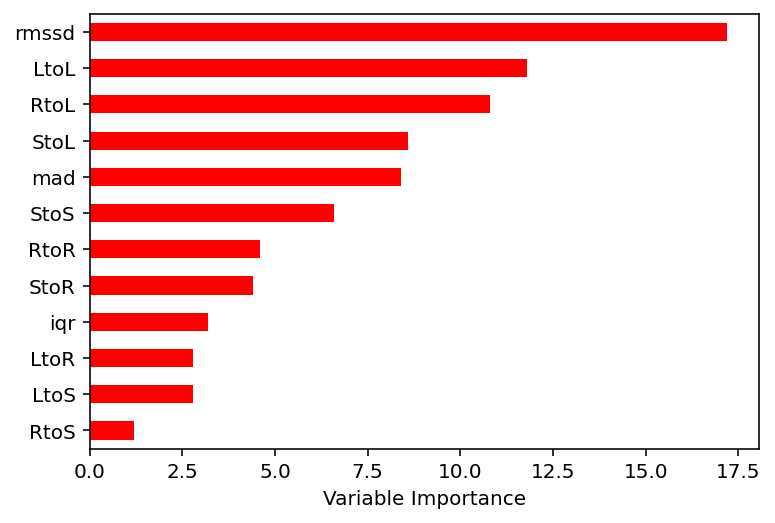

In [9]:
# AdaBoost
moving_accuracy['adaboost'] = []
params = {
    "n_estimators": np.linspace(100, 500, 5).astype(int)
}

moving_acc = []

print("random search started")
randomsearch = RandomizedSearchCV(AdaBoostClassifier(learning_rate = 0.1, algorithm="SAMME.R", random_state=2), 
                                    param_distributions=params, refit='accuracy', scoring=scorer, verbose=2, cv=splits)
randomsearch.fit(X, y)
print("random search completed")

moving_accuracy['adaboost'] = moving_acc[(randomsearch.best_index_)*23:(randomsearch.best_index_*23)+23]

print(randomsearch.best_estimator_.feature_importances_)
Importance = pd.DataFrame({'Importance':(randomsearch.best_estimator_.feature_importances_*100)[0:12]}, 
                      index = (X.columns)[0:12])
Importance.sort_values(by = 'Importance', 
                   axis = 0, 
                   ascending = True).plot(kind = 'barh', 
                                          color = 'r')
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

results = pd.DataFrame(randomsearch.cv_results_)
os.mkdir(os.path.normpath(parent_path + '/models/subsets/results/'))
results.to_csv(os.path.normpath(parent_path + '/models/subsets/results/adaboost_results.csv'))
print(results)

score_reporter(results.iloc[randomsearch.best_index_])

print(randomsearch.best_params_)

In [15]:
# Gradient boost (sklearn)
moving_accuracy['gradboost'] = []
params = {
    #"max_depth": list(range(1, 11)),
    #"n_estimators": np.linspace(100, 300, 5).astype(int)
    "max_depth": [9],
    "n_estimators": [450]
}

moving_acc = []

print("random search started")
randomsearch = RandomizedSearchCV(GradientBoostingClassifier(learning_rate = 0.1, random_state = 2), 
                                    param_distributions=params, refit='accuracy', scoring=scorer, verbose=2, cv=splits, n_iter=5)
randomsearch.fit(X, y)
print("random search completed")

moving_accuracy['gradboost'] = moving_acc[(randomsearch.best_index_)*23:(randomsearch.best_index_*23)+23]

print(randomsearch.best_estimator_.feature_importances_)
Importance = pd.DataFrame({'Importance':(randomsearch.best_estimator_.feature_importances_*100)[0:12]}, 
                      index = (X.columns)[0:12])
Importance.sort_values(by = 'Importance', 
                   axis = 0, 
                   ascending = True).plot(kind = 'barh', 
                                          color = 'r')
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

results = pd.DataFrame(randomsearch.cv_results_)
os.mkdir(os.path.normpath(parent_path + '/models/subsets/results/'))
results.to_csv(os.path.normpath(parent_path + '/models/subsets/results/gradboost_results.csv'))
print(results)

score_reporter(results.iloc[randomsearch.best_index_])

print(randomsearch.best_params_)

random search started
Fitting 23 folds for each of 1 candidates, totalling 23 fits


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


IndexError: list index out of range

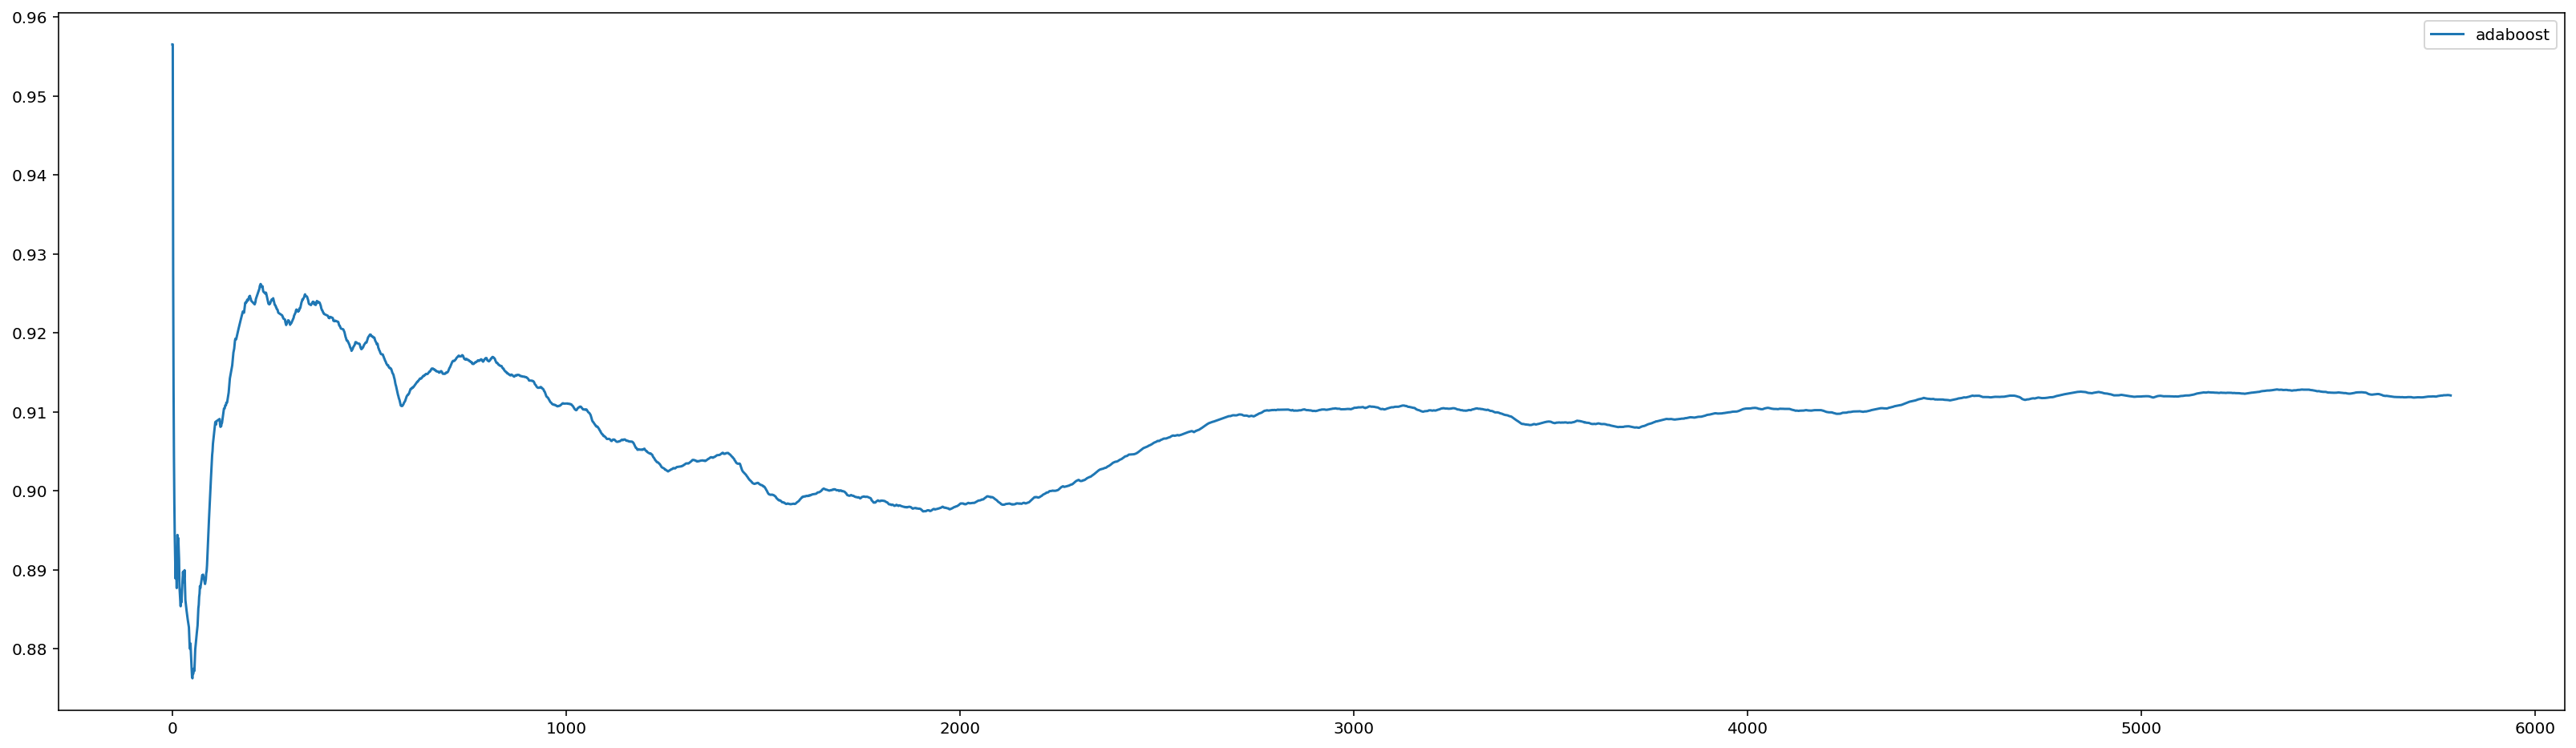

In [ ]:
plt.figure(figsize=(28, 8))
for classifier in moving_accuracy:
    minLen = len(moving_accuracy[classifier][0])
    for list in moving_accuracy[classifier]:
        if len(list)<minLen:
            minLen = len(list)

    for list in moving_accuracy[classifier]:
        list = list[:minLen]

    avg_list = [sum(sub_list) / len(sub_list) for sub_list in zip(*moving_accuracy[classifier])]
    plt.plot(avg_list, label = classifier)
    plt.legend()